In [1]:
%reset -f
%matplotlib widget

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sympy as sp
from sympy import Rational as frac

#enable latex rendering
sp.init_printing()

###################################################################################################################
l1 = 1.1  # First arm
l2 = 1  # Second arm
g = 9.81  # gravity
μ1 = 0.8  # friction coefficient first joint
μ2 = 0.8  # friction coefficient second joint
m1 = 1  # mass of the first pendulum
m2 = 1.1  # mass of the second pendulum
mc = 1.2  # mass of the cart

dt = 0.01  # time step
SIMT = 30

# use lagrangian mechanics to derive the equations of motion
# define the symbolic variables
t = sp.symbols('t')
θ1, θ2, xc = sp.symbols(r'\theta_1 \theta_2 x_c', cls=sp.Function)
#define as functions of time
θ1, θ2 = θ1(t), θ2(t) # angles of the joints
ω1, ω2 = θ1.diff(t), θ2.diff(t) # angular velocities of the joints
α1, α2 = ω1.diff(t), ω2.diff(t) # angular accelerations of the joints
xc = xc(t) # position of the cart
v = xc.diff(t) # velocity of the cart
a = v.diff(t) # acceleration of the cart

#define position of all the masses
x1, y1 = xc + l1*sp.sin(θ1), -l1*sp.cos(θ1) # position of the first pendulum
x2, y2 = x1 + l2*sp.sin(θ2), y1 - l2*sp.cos(θ2) # position of the second pendulum

# define the kinetic energy of the system
T1 = frac(1,2)*m1*(x1.diff(t)**2 + y1.diff(t)**2) # kinetic energy of the first pendulum
T2 = frac(1,2)*m2*(x2.diff(t)**2 + y2.diff(t)**2) # kinetic energy of the second pendulum
Tc = frac(1,2)*mc*v**2 # kinetic energy of the cart
T = T1 + T2 + Tc # total kinetic energy

# define the potential energy of the system
V = m1*g*y1 + m2*g*y2 # total potential energy

# define the lagrangian
L = T - V

# get the lagrange equations
LEQθ1 = ((L.diff(ω1)).diff(t) - L.diff(θ1)).simplify()
LEQθ2 = ((L.diff(ω2)).diff(t) - L.diff(θ2)).simplify()
LEQxc = ((L.diff(v)).diff(t) - L.diff(xc)).simplify()
print('Lagrange equations derived')

# solve the lagrange equations
α1 = sp.solve(LEQθ1, α1)[0] #- μ1*ω1
α2 = sp.solve(LEQθ2, α2)[0] #- μ2*ω2
a = sp.solve(LEQxc, a)[0]
print('Lagrange equations solved')

# lambdify the equations
# model_α1 = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v, α2, a), α1, 'numpy') 
# model_α2 = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v, α1, a), α2, 'numpy') 
# model_a  = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v, α1, α2), a, 'numpy') 
model_α1 = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v), α1, 'numpy')
model_α2 = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v), α2, 'numpy') 
model_a  = sp.lambdify((t, θ1, θ2, xc, ω1, ω2, v), a, 'numpy') 
print('Model lambdified')






Lagrange equations derived
Lagrange equations solved
Model lambdified


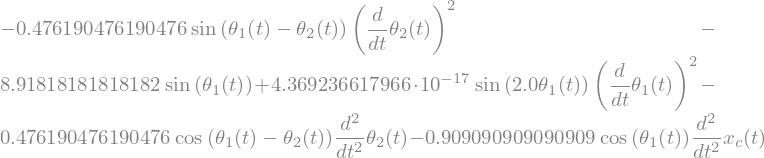

In [3]:
α1

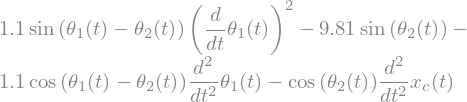

In [4]:
α2

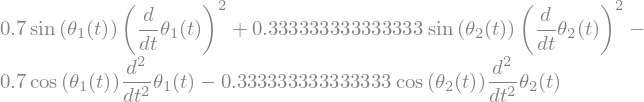

In [5]:
a

In [7]:

# Integrate the differential equation
nt = np.arange(0, SIMT, dt)
nθ1, nω1, nα1 = np.zeros_like(nt), np.zeros_like(nt), np.zeros_like(nt)
nθ2, nω2, nα2 = np.zeros_like(nt), np.zeros_like(nt), np.zeros_like(nt)
nxc, nv, na = np.zeros_like(nt), np.zeros_like(nt), np.zeros_like(nt)

for i in range(1, len(nt)):
    # nα1[i] = model_α1(0, nθ1[i-1], nω1[i-1], nθ2[i-1], nω2[i-1], nα2[i-1], nxc[i-1], nv[i-1], na[i-1])
    # nα2[i] = model_α2(0, nθ1[i-1], nω1[i-1], nα1[i-1], nθ2[i-1], nω2[i-1], nxc[i-1], nv[i-1], na[i-1])
    # na[i] = model_a(0, nθ1[i-1], nω1[i-1], nα1[i-1], nθ2[i-1], nω2[i-1], nα2[i-1], nxc[i-1], nv[i-1])
    nα1[i] = model_α1(0, nθ1[i-1], nθ2[i-1], nxc[i-1], nω1[i-1], nω2[i-1], nv[i-1])
    nα2[i] = model_α2(0, nθ1[i-1], nθ2[i-1], nxc[i-1], nω1[i-1], nω2[i-1], nv[i-1])
    na[i] = model_a(0, nθ1[i-1], nθ2[i-1], nxc[i-1], nω1[i-1], nω2[i-1], nv[i-1])
    nω1[i] = nω1[i-1] + nα1[i]*dt
    nω2[i] = nω2[i-1] + nα2[i]*dt
    nv[i] = nv[i-1] + na[i]*dt
    nθ1[i] = nθ1[i-1] + nω1[i]*dt
    nθ2[i] = nθ2[i-1] + nω2[i]*dt
    nxc[i] = nxc[i-1] + nv[i]*dt
print('Differential equation integrated')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
lim = (l1+l2)*1.2
ax.set_xlim(-lim, lim), ax.set_ylim(-lim, lim)
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]')
ax.set_title('Double pendulum on a cart')

line1, = ax.plot([], [], 'o-', lw=2, color='blue')
line2, = ax.plot([], [], 'o-', lw=2, color='red')
cart, = ax.plot([], [], 's', lw=2, color='black')

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    cart.set_data([], [])
    time_text.set_text('')
    return line1, line2, cart, time_text

def animate(i):
    x1 = l1*np.sin(nθ1[i])
    y1 = -l1*np.cos(nθ1[i])
    x2 = x1 + l2*np.sin(nθ2[i])
    y2 = y1 - l2*np.cos(nθ2[i])
    line1.set_data([0, x1], [0, y1])
    line2.set_data([x1, x2], [y1, y2])
    cart.set_data([nxc[i], 0])
    time_text.set_text(time_template % (i*dt))
    return line1, line2, cart, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(nt)), init_func=init, interval=dt*1000, blit=True)
plt.show()

NameError: name 'Derivative' is not defined

In [ ]:
α1

In [ ]:
α2

In [ ]:
a